In [19]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [20]:
img_array = cv2.imread("train/0/Training_3908.jpg")

In [21]:
img_array.shape # rgb

(48, 48, 3)

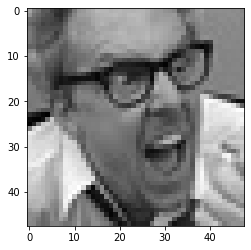

In [22]:
plt.imshow(img_array) #BGR

In [23]:
dataDirectory = "train/" # training data set directory

In [24]:
classes = ["0","1","2","3","4","5","6"] # angry, disgust, fear, happy, neutral, sad, surprise directory

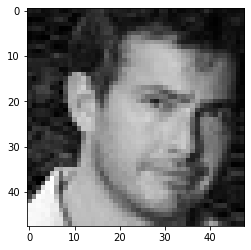

In [25]:
for category in classes:
    path = os.path.join(dataDirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        #backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break   
    break

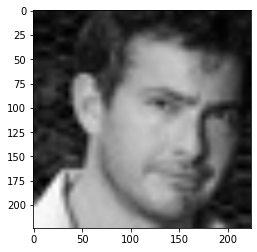

In [26]:
img_size = 224 ## ImageNet 224x224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

## read all the images and convert them to array

In [27]:
training_data = [] ## data dict

def create_training_data ():
    for category in classes:
        path = os.path.join(dataDirectory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
        
print(training_data)

[]


In [28]:
create_training_data()

In [29]:
print(len(training_data))

28708


In [30]:
temp = np.array(training_data)
print(temp.shape)

(28708, 2)


<ipython-input-30-504a8a27d82d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp = np.array(training_data)


In [31]:
import random

random.shuffle(training_data)

In [32]:
x = [] ## data /feature
y = [] ## label

for features, label, in training_data:
    x.append(features)
    y.append(label)
    
x = np.array(x).reshape(-1, img_size, img_size, 3) ## converting it to 4 dimension

In [33]:
x.shape

(28708, 224, 224, 3)

In [34]:
#normalize the data

x = x/255.0

In [35]:
type(y)

list

In [36]:
Y = np.array(y)

In [37]:
Y.shape

(28708,)

# deep learning model for training - Transfer Learning

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [39]:
model = tf.keras.applications.MobileNetV2() ## Pre-Trained Model

In [40]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# Transfer Learning - Tuning, weights will start from last check point

In [45]:
base_input = model.layers[0].input ## input
base_output = model.layers[-2].output


In [46]:
base_ouput


<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d_1')>

In [47]:
final_output = layers.Dense(128)(base_output)
final_ouput = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(base_ouput)
final_ouput = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_ouput)

In [48]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_5')>

In [49]:
new_model = keras.Model(inputs = base_input, outputs = final_output)
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [50]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [51]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [52]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

new_model.fit(x[:2000],Y[:2000],
          batch_size=32,
          epochs=5,
          validation_split=0.3
             ,callbacks=[tensorboard_callback])

Epoch 1/5
44/44 [==============================] - 31s 399ms/step - loss: 1.8399 - accuracy: 0.2896 - val_loss: 4.4528 - val_accuracy: 0.1633
Epoch 2/5
44/44 [==============================] - 11s 245ms/step - loss: 1.2673 - accuracy: 0.5327 - val_loss: 3.1890 - val_accuracy: 0.2483
Epoch 3/5
44/44 [==============================] - 11s 244ms/step - loss: 0.9868 - accuracy: 0.6504 - val_loss: 4.8499 - val_accuracy: 0.2667
Epoch 4/5
44/44 [==============================] - 11s 247ms/step - loss: 0.8880 - accuracy: 0.6806 - val_loss: 10.0290 - val_accuracy: 0.1583
Epoch 5/5
44/44 [==============================] - 11s 243ms/step - loss: 0.7096 - accuracy: 0.7339 - val_loss: 10.5300 - val_accuracy: 0.2250


In [34]:
new_model.save('my_model_64p35.h5')
#new_model = tf.keras.models.load_model('my_model64p35.h5')